In [1]:
import tensorflow as tf

import time
import os
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt

from IPython import display

## Load the MNIST dataset

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images /= 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images /= 255.0

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [4]:
TRAIN_BUFFER_SIZE = 60000
BATCH_SIZE = 128
TEST_BUFFER_SIZE = 10000

## Use tf.data to create batches and shuffle the dataset

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUFFER_SIZE).batch(BATCH_SIZE)

## Wire up the generative and inference network with tf.keras.Sequential

In our VAE example, we use two small ConvNets for the generative and inference network. since these neural nets are small, we use tf.keras.Sequential to simplify our code. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

__Generative Network__  
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x | z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

__Inference Network__  
This defines an approximate posterior distribution $q(z | x),$ which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

__Reparameterization Trick__  
During optimization, we can sample from $q(z | x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

__Network architecture__  
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolutional transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's commom practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [6]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, strides=(2,2), activation='relu'), # [None, 13, 13, 32]
            tf.keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'), # [None, 6, 6, 64]
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(self.latent_dim + self.latent_dim)
        ])
        self.generative_net = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
            tf.keras.layers.Dense(7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2),
                                            padding='SAME',
                                            activation='relu'), # [None, 14, 14, 64] 
            tf.keras.layers.Conv2DTranspose(32, 3, strides=(2,2),
                                            padding='SAME',
                                            activation='relu'), # [None, 28, 28, 32]
            # No activation
            tf.keras.layers.Conv2DTranspose(1, 3, strides=(1,1), padding='SAME') # [None, 28, 28, 1]
        ])
    
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:
$$
\log p(x) \geq \mathrm{ELBO}=\mathbb{E}_{q(z | x)}\left[\log \frac{p(x, z)}{q(z | x)}\right]
$$
In practice, we optimize the single sample Monte Carlo estimate of this expectation:
$$
\log p(x | z)+\log p(z)-\log q(z | x)
$$
where $z$ is sampled from $q(z | x)$

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2.0 * np.pi)
    return tf.reduce_sum(
        -0.5 * ((sample - mean)**2.0 * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis
    )

@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logits = model.decode(z)
    
    cross_net = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logits, labels=x)
    logpx_z = -tf.reduce_sum(cross_net, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0.0, 0.0)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

In [8]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [9]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04f}.png'.format(epoch))
    plt.show()

Epoch: 100, Test set ELBO: -77.29595184326172, time elapse for current epoch 2.830385446548462


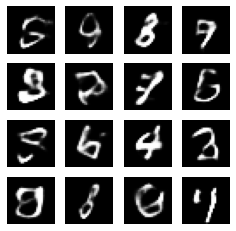

In [11]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        display.clear_output(wait=True)
        print('Epoch: {}, Test set ELBO: {}, '
              'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
        generate_and_save_images(
            model, epoch, random_vector_for_generation)

In [12]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
    display.Image(filename=anim_file)

In [20]:
for _ in glob.glob("image*"):
    !rm {_}